In [49]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [50]:
# Problem 1
# data setup ; no dir, files in same wd()
Q = np.loadtxt('FOL-daily.csv', delimiter=',', skiprows=1, usecols=[4])

T = len(Q)
# Initialize state vectors
S = np.zeros(T)
R = np.zeros(T)
W = np.zeros(T) # Spill vector

In [51]:
def storage_to_elevation(S): # from regression
  return -0.000078*S**2 + 0.213526*S + 328.922121

In [52]:
# Part A, B, C
def simulate_folsom(Q, K, D):
# overly-simplified reservoir simulation for Oroville
    S[0] = K
    R[0] = D
    
    cfs_to_taf = 2.29568411*10**-5 * 86400 / 1000
    turbine_max_outflow = 8600 # cfs
    turbine_max_outflow_taf = turbine_max_outflow*cfs_to_taf
    downstream_use = 134 # in ft
    efficiency = 0.82 # for hydropower generation

# Setting the initial condition

    for t in range(1,T):

          # new storage: mass balance, max value is K
          S[t] = min(S[t-1] + Q[t-1] - R[t-1], K)
        # storage today = storage yesterday + inflow yesterday + released yesterday
          # release is based on demand
            # if storage and inflow > demand, release=demand
            #else: release = storage + inflow
          if S[t] + Q[t] > D:
            R[t] = D
          else:
            R[t] = S[t] + Q[t]
            
          # calc 1st entry of Spill by t-1
          W[t-1] = max(S[t-1] + Q[t-1] - R[t-1] - K, 0)
       
    # time period in which demand is met / total time period
    reliability = R[R==D].size / float(T) * 100
    print("Reliability:",reliability, "%")
    alteration = np.sum(np.abs(R + W - Q)) / np.sum(Q) * 100
    print("Alteration:", alteration, "%")
    q_powergen = np.clip(R+W, a_min = R+W, a_max = turbine_max_outflow_taf) 
    
    s_e_head = storage_to_elevation(S)
    head_adj = s_e_head - downstream_use
    power_total = (head_adj*efficiency*q_powergen/cfs_to_taf/ (1.181*10000))

    plt.figure(figsize=[10,8])
    plt.plot(power_total, label = "Hydropower")
    plt.xlabel('Days from Oct. 1st 2000')
    plt.ylabel('MW')
    plt.legend()
    plt.show()

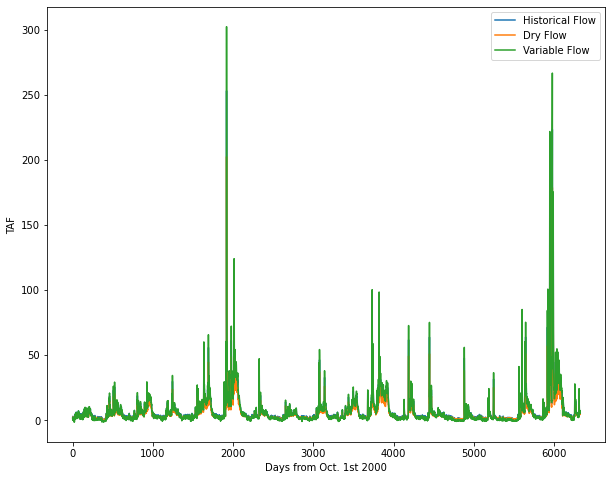

In [54]:
# Part D
dry_flow = .8*Q
mean_flow = sum(Q) / len(Q)
anomalie_flow = Q - mean_flow
variable_flow = anomalie_flow * 1.2 + mean_flow

plt.figure(figsize=[10,8])
plt.plot(Q, label = "Historical Flow")
plt.plot(dry_flow, label = "Dry Flow")
plt.plot(variable_flow, label = "Variable Flow")
plt.xlabel('Days from Oct. 1st 2000')
plt.ylabel('TAF')
plt.legend()
plt.show()

Historical Flow
Reliability: 99.55703211517165 %
Alteration: 18.120571855900675 %


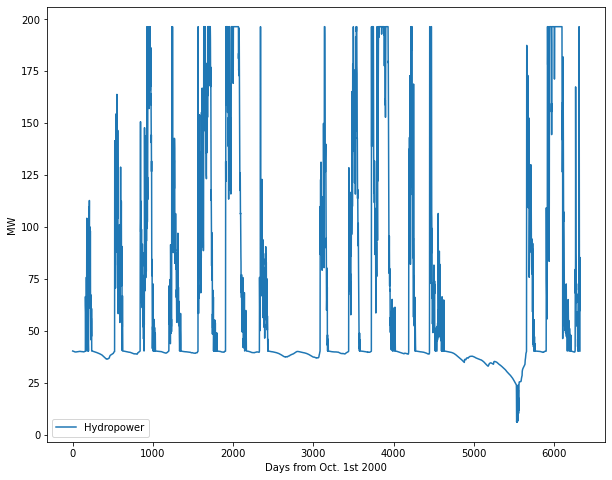

Dry Flow
Reliability: 96.69356114538839 %
Alteration: 28.661111290705392 %


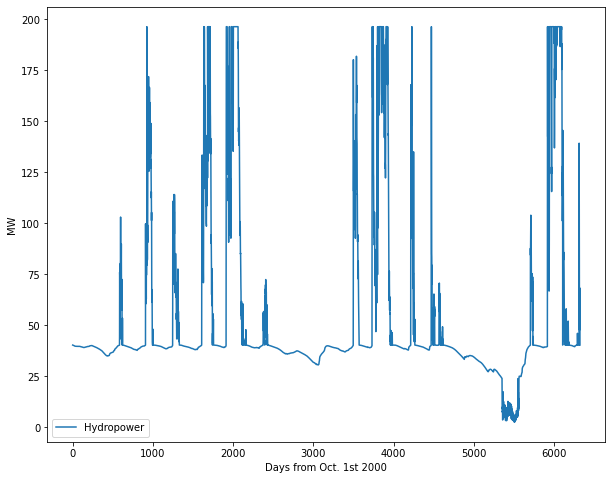

Variable Flow
Reliability: 95.52286030691346 %
Alteration: 27.858879054775006 %


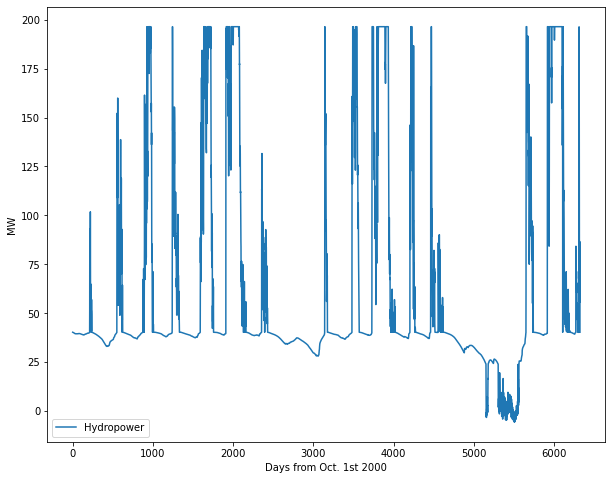

Historical Flow has the highest reliability percentage, the lowest alteration percentage, and consistently high power generation.
Dry Flow, has the second lowest reliability, the highest alteration, and the worst power generation.
Variable Flow has the lowest reliability, the second highest alteration, and worse power generation than historical flow, but better than dry flow.

Intuitively, dry flow results in less flow to meet demand (reliaibility) and generate power.

Alteration is highest for dry flow. This may be due to there being less flow overall compared to what is being regularly released and spilled. While a 96.7% reliability is less than 99.6%, demand is still being met most of the time.

Variable Flow seems to have the lowest reliability (95.5%) because of its inherent variability, making it more difficult to meet demand than the other streamflow scenarios.


In [55]:
# Part A, B, C, D, E
# Set some parameters # capacity, TAF
K = 975
D = 3.5 # target demand, TAF/daily
print("Historical Flow")
simulate_folsom(Q, K, D) # getting 30 vs 18 dep on using t or t-1 for r, t
print("Dry Flow")
simulate_folsom(dry_flow, K, D)
print("Variable Flow")
simulate_folsom(variable_flow, K, D)

print("Historical Flow has the highest reliability percentage, the lowest alteration percentage, and consistently high power generation.")
print("Dry Flow, has the second lowest reliability, the highest alteration, and the worst power generation.")
print("Variable Flow has the lowest reliability, the second highest alteration, and worse power generation than historical flow, but better than dry flow.")
print("\n" + "Intuitively, dry flow results in less flow to meet demand (reliaibility) and generate power.")
print("\n" + "Alteration is highest for dry flow. This may be due to there being less flow overall compared to what is being regularly released and spilled. While a 96.7% reliability is less than 99.6%, demand is still being met most of the time.")
print("\n" + "Variable Flow seems to have the lowest reliability (95.5%) because of its inherent variability, making it more difficult to meet demand than the other streamflow scenarios.")


In [56]:
# Problem 2
# Import data; All units in MCM
data = pd.read_csv('net_inflow.csv', header=None, names=['Year', 'Inflow'])
data = data[data['Year']>=2000]
pipeline = np.loadtxt('pipeline_availability.csv', delimiter=',')
demand = np.loadtxt('demand.csv', delimiter=',')
data['Pipeline'] = pipeline[:,1]
data['Demand'] = demand[:,1]
del demand, pipeline
data = data.set_index('Year')

In [57]:
# Define Constants
desalCapacity= 150 # MCM
reservoirCapacity = 1812 # MCM
initialStorage = 1148 # MCM
pipelineCost = 0.28 # $ per cubic meter
desalCost = 0.45 # $ per cubic meter

# %% Simulate system 
# Initialize four state variables: storage, ppeline water imports, desal water imports, unmet demand
storage = np.zeros(len(data))
demandMet = np.zeros_like(storage)

# Define operating rules
thresh_storage = 580

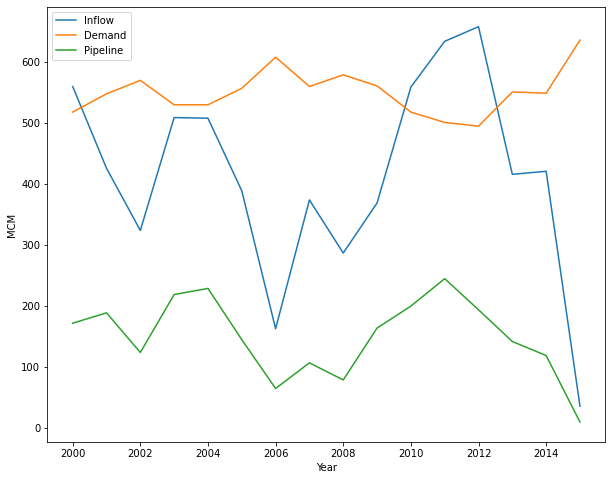

No, Melbourne would not be able to supply all their demand from local water if they had infinite water storage
Demand increases near end of time period where inflow and pipeline availability both decrease, indicating a need for another source of water to meet demand.
Even with maximum storage, inflow and availability are much less than demand during very dry years (2006).


In [58]:
# Part A
plt.figure(figsize=[10,8])
plt.plot(data['Inflow'], label = "Inflow")
plt.plot(data['Demand'], label = "Demand")
plt.plot(data['Pipeline'], label = "Pipeline")
plt.xlabel('Year')
plt.ylabel('MCM')
plt.legend()
plt.show()
print("No, Melbourne would not be able to supply all their demand from local water if they had infinite water storage")
print("Demand increases near end of time period where inflow and pipeline availability both decrease, indicating a need for another source of water to meet demand.")
print("Even with maximum storage, inflow and availability are much less than demand during very dry years (2006).")

In [59]:
# model before other inputs
# Loop over time range
for i in range(len(storage)):

    # Get starting storage level
    if i == 0:
        storage[i] = initialStorage
    else:
        storage[i] = storage[i-1]

    # Add net inflows to storage
    storage[i] = storage[i] + data['Inflow'].iloc[i]

    # Meet as much demand as possible, without going below min level
    storageAvail = np.max([storage[i] - thresh_storage, 0])
    storageUsed = np.min([data['Demand'].iloc[i], storageAvail])
    demandMet[i] = storageUsed
    storage[i] = storage[i] - storageUsed

In [60]:
# %% Calculate Performance Objectives
# Part B
# Calculate total unmet demand from 2000 to 2015
demandUnmet = data['Demand'] - demandMet
demandUnmet_Total = demandUnmet.sum(axis=0)
print("Total unmet water demand from 2000-2015:",demandUnmet_Total, "MCM")

# Maximum volume of unmet demand in any year
demandUnmet_Max = demandUnmet.max(axis=0)
print("Maximum volume of unmet demand in any year between 2000-2015:",demandUnmet_Max, "MCM")

Total unmet water demand from 2000-2015: 1610.0 MCM
Maximum volume of unmet demand in any year between 2000-2015: 526.0 MCM


In [61]:
# Part C
desal_used = np.zeros_like(storage)
pipeline_used = np.zeros_like(storage)

# Loop over time range
for i in range(len(storage)):

    # Get starting storage level
    if i == 0:
        storage[i] = initialStorage
    else:
        storage[i] = storage[i-1]

    # Add net inflows to storage
    storage[i] = storage[i] + data['Inflow'].iloc[i]

    if storage[i] < 1200:
        storage[i] = storage[i] + data['Pipeline'].iloc[i]
        pipeline_used[i] = data['Pipeline'].iloc[i]
        
        
    if storage[i] < 900:
        storage[i] = storage[i] + desalCapacity
        desal_used[i] = desalCapacity
        
    # Meet as much demand as possible, without going below min level
    storageAvail = np.max([storage[i] - thresh_storage, 0])
    storageUsed = np.min([data['Demand'].iloc[i], storageAvail])
    demandMet[i] = storageUsed
    storage[i] = storage[i] - storageUsed   

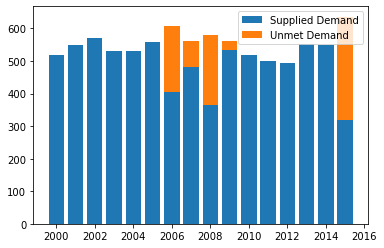

In [62]:
# Part D
# Plot met and unmet demand in stacked bar chart
demandUnmet = data['Demand'] - demandMet
plt.figure()
plt.bar(data.index, demandMet, label='Supplied Demand')
plt.bar(data.index, demandUnmet, label='Unmet Demand', bottom=demandMet)
plt.legend()
plt.show()

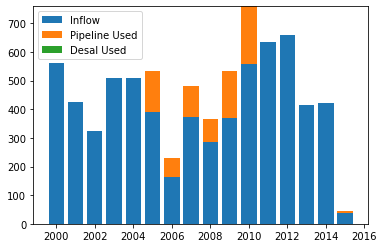

In [63]:
# Part D
# Plot water supplied by source
plt.figure()
plt.bar(data.index, data["Inflow"], label='Inflow')
plt.bar(data.index, pipeline_used, label='Pipeline Used',bottom=data["Inflow"])
plt.bar(data.index, desal_used, label='Desal Used', bottom = data["Inflow"] + pipeline_used)
plt.legend()
plt.show()

In [64]:
# Part D
# Calculate total unmet demand from 2000 to 2015
demandUnmet_Total = demandUnmet.sum(axis=0)
print("Total demand unmet between 2000-2015:", demandUnmet_Total, "MCM")

# Maximum volume of unmet demand in any year
demandUnmet_Max = demandUnmet.max(axis=0)
print("Maximum demand unmet in any year between 2000-2015:", demandUnmet_Max, "MCM")

pipeline_used_Total = pipeline_used.sum(axis=0)
pipeline_supply_cost = pipeline_used_Total * pipelineCost

if desal_used.any() > 0:
    storage_desal_used = desal_used.sum(axis=0)
    storage_desal_cost = storage_desal_used * desalCost
else: 
    storage_desal_cost = 0
    
water_supply_cost = round(storage_desal_cost + pipeline_supply_cost)
print("Cost of supplying water: $", water_supply_cost, "million")

Total demand unmet between 2000-2015: 840.0 MCM
Maximum demand unmet in any year between 2000-2015: 316.0 MCM
Cost of supplying water: $ 216 million


In [65]:
# Part E, Water Balance
# Calculate change in storage
supply = data['Inflow'] + pipeline_used + desal_used
Delta_S = supply - demandMet

# demandMet = storage used
# Delta S - supply + demand = 0

# Verification of Water Balance equaling 0
wb = Delta_S - supply + demandMet
print(wb)
print("\n" + "Water Balance = 0")

Year
2000    0.0
2001    0.0
2002    0.0
2003    0.0
2004    0.0
2005    0.0
2006    0.0
2007    0.0
2008    0.0
2009    0.0
2010    0.0
2011    0.0
2012    0.0
2013    0.0
2014    0.0
2015    0.0
Name: Inflow, dtype: float64

Water Balance = 0


In [66]:
# Part F
def melbourne_analysis(storage, data, pipeline_threshold, desal_threshold):

    desal_used = np.zeros_like(storage)
    pipeline_used = np.zeros_like(storage)

    # Loop over time range
    for i in range(len(storage)):

        # Get starting storage level
        if i == 0:
            storage[i] = initialStorage
        else:
            storage[i] = storage[i-1]

        # Add net inflows to storage
        storage[i] = storage[i] + data['Inflow'].iloc[i]

        if storage[i] < pipeline_threshold:
            storage[i] = storage[i] + data['Pipeline'].iloc[i]
            pipeline_used[i] = data['Pipeline'].iloc[i]


        if storage[i] < desal_threshold:
            storage[i] = storage[i] + desalCapacity
            desal_used[i] = desalCapacity

        # Meet as much demand as possible, without going below min level
        storageAvail = np.max([storage[i] - thresh_storage, 0])
        storageUsed = np.min([data['Demand'].iloc[i], storageAvail])
        demandMet[i] = storageUsed
        storage[i] = storage[i] - storageUsed   

    # Calculate total unmet demand from 2000 to 2015
    demandUnmet = data['Demand'] - demandMet
    demandUnmet_Total = demandUnmet.sum(axis=0)
    print("Total demand unmet between 2000-2015:", demandUnmet_Total, "MCM")

    # Maximum volume of unmet demand in any year
    demandUnmet_Max = demandUnmet.max(axis=0)
    print("Maximum demand unmet in any year between 2000-2015:", demandUnmet_Max, "MCM")

    pipeline_used_total = pipeline_used.sum(axis=0)
    pipeline_supply_cost = pipeline_used_total * pipelineCost

    if desal_used.any() > 0:
        storage_desal_used = desal_used.sum(axis=0)
        storage_desal_cost = storage_desal_used * desalCost
    else: 
        storage_desal_cost = 0

    water_supply_cost = round(storage_desal_cost + pipeline_supply_cost)
    print("Cost of supplying water: $", water_supply_cost, "million")

In [67]:
# Part F
# Scenario A
pipeline_threshold = 1000
desal_threshold = 1000
melbourne_analysis(storage, data, pipeline_threshold, desal_threshold)

# Scenario B
pipeline_threshold = 1100
desal_threshold = 900
melbourne_analysis(storage, data, pipeline_threshold, desal_threshold)

# Scenario C
pipeline_threshold = 1200
desal_threshold = 1200
melbourne_analysis(storage, data, pipeline_threshold, desal_threshold)

# Scenario D
pipeline_threshold = 1200
desal_threshold = 900
melbourne_analysis(storage, data, pipeline_threshold, desal_threshold)

Total demand unmet between 2000-2015: 735.0 MCM
Maximum demand unmet in any year between 2000-2015: 366.0 MCM
Cost of supplying water: $ 322 million
Total demand unmet between 2000-2015: 885.0 MCM
Maximum demand unmet in any year between 2000-2015: 366.0 MCM
Cost of supplying water: $ 254 million
Total demand unmet between 2000-2015: 290.0 MCM
Maximum demand unmet in any year between 2000-2015: 236.0 MCM
Cost of supplying water: $ 497 million
Total demand unmet between 2000-2015: 840.0 MCM
Maximum demand unmet in any year between 2000-2015: 316.0 MCM
Cost of supplying water: $ 216 million


In [68]:
# Part F
tableF  = {'Scenario (Years: 2000-2015)': ['A (1000,1000)','B (1100,900)','C (1200,1200)','D (1200,900)'], 'Total Unmet Demand': ['735 MCM','885 MCM','290 MCM','840 MCM'], 'Max Unmet Demand, any year': ['366 MCM', '366 MCM','236 MCM', '316 MCM'], 'Cost': ['$322 million','$254 million', '$497 million', '$216 million']}
tableF = pd.DataFrame(tableF)
print(tableF)

print("\n" + 'None of the operating policies are Pareto dominated, as each scenario improves on one or more objective while making another worse. While higher desalination thresholds significantly reduce unmet demand, they significantly increase cost.')

print("\n" + 'Comparing scenarios A and B shows that while they both have the same value for max unmet demand at 366 MCM, scenario B results in more unmet demand at 885 MCM for a lower price at $254 million compared to $322 million for scenario A.')
print('Comparing scenarios B and C shows that raising the thresholds to 1200 MCM for both drastically reduces total unmet demand, max unmet demand, yet raises the cost of water to $497 million (nearly 2x that of scenario B).')
print('Comparing scenarios C and D shows that maintaining the pipeline threshold at 1200 while reducing the desal threshold to 900 drastically increases total unmet demand to 840 MCM, raises max unmet demand to 316 MCM, while significantly lowering the cost of water to $216 million.')
print('Comparing scenarios A and D shows that the threshold changes in D raise total unmet demand to 840 MCM vs. 735 MCM, lowers max unmet demand to 316 vs. 366 MCM, while lowering costs to $216 million.')
print('Comparing scenarios A and C shows that raising the thresholds significantly lowers unmet demand to 290 MCM, max unmet demand to 236 MCM,  yet raises the cost of water to $497 million.')
print('Comparing scenarios B and D shows that D has slightly less unmet demand (although 840 MCM is still high), slightly less max unmet demand at 316 MCM, and significantly less cost of water at $216 million.')

print("\n" + 'Across operating policies, the total unmet demand metric shows the greatest tradeoff, as total unmet demand remains high (>= 735 MCM) until a desalination threshold of 1200 MCM. When both thresholds are at 1200 MCM, total unmet demand drops to 290 MCM. Also, raising both thresholds to 1200 MCM yields a cost 1.5-2.3x higher than the rest of the scenarios.')


  Scenario (Years: 2000-2015) Total Unmet Demand Max Unmet Demand, any year  \
0               A (1000,1000)            735 MCM                    366 MCM   
1                B (1100,900)            885 MCM                    366 MCM   
2               C (1200,1200)            290 MCM                    236 MCM   
3                D (1200,900)            840 MCM                    316 MCM   

           Cost  
0  $322 million  
1  $254 million  
2  $497 million  
3  $216 million  

None of the operating policies are Pareto dominated, as each scenario improves on one or more objective while making another worse. While higher desalination thresholds significantly reduce unmet demand, they significantly increase cost.

Comparing scenarios A and B shows that while they both have the same value for max unmet demand at 366 MCM, scenario B results in more unmet demand at 885 MCM for a lower price at $254 million compared to $322 million for scenario A.
Comparing scenarios B and C shows that r

With the models developed in this assignment, it is not a problem that the maximum storage capacity (1812 MCM) was not used.
In this simulation, water was only imported once the storage fell below a certain threshold. Even then, the amount of water imported stayed significantly under the maximum storage capacity.


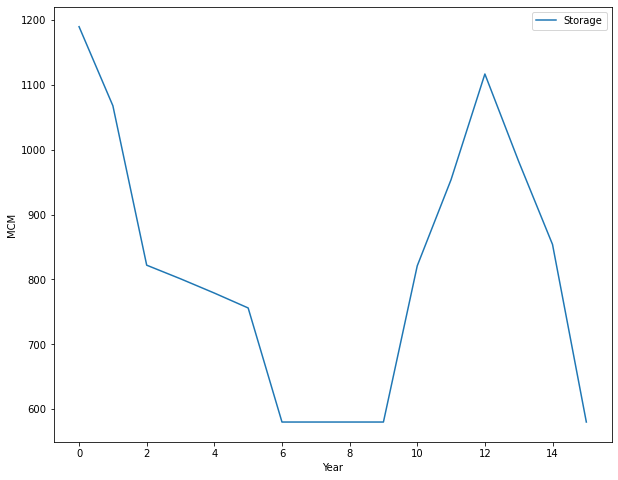

As this timeseries plot of storage demonstrates, storage only got close to its initial value of 1148 once.
Not using the maximum storage capacity parameter may become a problem if higher threshold values are set.
A simple way to address this issue would be to include this parameter in reservoir simulation as a max value preventing water to be imported if it were to exceed the maximum storage capacity with a safety factor applied.


In [69]:
# Part G
print('With the models developed in this assignment, it is not a problem that the maximum storage capacity (1812 MCM) was not used.')
print('In this simulation, water was only imported once the storage fell below a certain threshold. Even then, the amount of water imported stayed significantly under the maximum storage capacity.')

plt.figure(figsize=[10,8])
plt.plot(storage, label = "Storage")
plt.xlabel('Year')
plt.ylabel('MCM')
plt.legend()
plt.show()

print("As this timeseries plot of storage demonstrates, storage only got close to its initial value of 1148 MCM once.")
print('Not using the maximum storage capacity parameter may become a problem if higher threshold values are set.')
print('A simple way to address this issue would be to include this parameter in reservoir simulation as a max value preventing water to be imported if it were to exceed the maximum storage capacity with a safety factor applied.')

In [70]:
# Part H
print('The assumption to lump all of the Melbourne reservoir storage into a stingle storage variable could lead to poor model performance under conditions in which individual reservoir storage thresholds are being encroached on.')
print('For example, drought conditions may affect individual reservoirs differently than others, as they may have different minimum storage levels, and varying sources of inflows that could be affected by drought.')
print('This would result in poor model performance as the model would not reflect the bottlenecks arising from reservoirs being affected in particular ways by conditions like droughts.')

The assumption to lump all of the Melbourne reservoir storage into a stingle storage variable could lead to poor model performance under conditions in which individual reservoir storage thresholds are being encroached on.
For example, drought conditions may affect individual reservoirs differently than others, as they may have different minimum storage levels, and varying sources of inflows that could be affected by drought.
This would result in poor model performance as the model would not reflect the bottlenecks arising from reservoirs being affected in particular ways by conditions like droughts.
